In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_bikes = pd.read_csv('../availability.csv')
df_bikes['time_stamp'] = pd.to_datetime(df_bikes['time_stamp']).dt.round('H')
df_bikes = df_bikes.groupby(['id', 'time_stamp']).agg({'bikes': 'mean', 'bike_stands': 'mean'}).reset_index()

In [3]:
def round_nearest(value):
    integer_part = int(value)
    fractional_part = value - integer_part
    if fractional_part >= 0.5:
        return integer_part + 1
    else:
        return integer_part

In [4]:
df_bikes['bikes'] = df_bikes['bikes'].apply(lambda x: round_nearest(x))
df_bikes['bike_stands'] = df_bikes['bike_stands'].apply(lambda x: round_nearest(x))

In [5]:
df_bikes.head()

,id,time_stamp,bikes,bike_stands
0,1,2024-01-01 00:00:00,23,8
1,1,2024-01-01 01:00:00,23,8
2,1,2024-01-01 02:00:00,23,8
3,1,2024-01-01 03:00:00,23,8
4,1,2024-01-01 04:00:00,23,8


In [6]:
len(df_bikes)

164160

In [7]:
df_weather = pd.read_csv('../hourlyWeather.csv')
df_weather['time_stamp'] = pd.to_datetime(df_weather['time_stamp']).dt.round('H')

In [8]:
df_weather.head()

,time_stamp,temp_c,feelslike_c,wind_kph,humidity,precip_mm,gust_kph,wind_degree,pressure_mb,cloud,uv
0,2024-01-01 00:00:00,5.8,1.1,30.1,84.33,0.078,50.0,257,994.4,64.9,0
1,2024-01-01 01:00:00,5.0,0.1,29.9,86.73,0.000,68.8,257,994.8,25.0,0
2,2024-01-01 02:00:00,4.8,-0.1,28.5,83.05,0.000,48.2,257,995.5,17.2,0
3,2024-01-01 03:00:00,4.5,0.0,24.0,83.87,0.000,42.5,254,996.4,17.3,0
4,2024-01-01 04:00:00,4.7,0.5,22.3,82.67,0.000,61.6,240,997.2,17.2,0


In [9]:
len(df_weather) * 114

164160

In [10]:
df = pd.merge(df_bikes, df_weather, on='time_stamp', how='inner')
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df.head()

,id,time_stamp,bikes,bike_stands,temp_c,feelslike_c,wind_kph,humidity,precip_mm,gust_kph,wind_degree,pressure_mb,cloud,uv
0,1,2024-01-01 00:00:00,23,8,5.8,1.1,30.1,84.33,0.078,50.0,257,994.4,64.9,0
1,1,2024-01-01 01:00:00,23,8,5.0,0.1,29.9,86.73,0.000,68.8,257,994.8,25.0,0
2,1,2024-01-01 02:00:00,23,8,4.8,-0.1,28.5,83.05,0.000,48.2,257,995.5,17.2,0
3,1,2024-01-01 03:00:00,23,8,4.5,0.0,24.0,83.87,0.000,42.5,254,996.4,17.3,0
4,1,2024-01-01 04:00:00,23,8,4.7,0.5,22.3,82.67,0.000,61.6,240,997.2,17.2,0


In [11]:
X = df[['time_stamp', 'id', 'temp_c', 'feelslike_c', 'wind_kph', 'humidity', 'precip_mm', 'gust_kph', 'wind_degree', 'pressure_mb', 'cloud', 'uv']]
X['time_stamp'] = (X['time_stamp'].astype(int) / 10**9).astype(int)
y = df[['bikes', 'bike_stands']]

In [12]:
X.head()

,time_stamp,id,temp_c,feelslike_c,wind_kph,humidity,precip_mm,gust_kph,wind_degree,pressure_mb,cloud,uv
0,1704067200,1,5.8,1.1,30.1,84.33,0.078,50.0,257,994.4,64.9,0
1,1704070800,1,5.0,0.1,29.9,86.73,0.000,68.8,257,994.8,25.0,0
2,1704074400,1,4.8,-0.1,28.5,83.05,0.000,48.2,257,995.5,17.2,0
3,1704078000,1,4.5,0.0,24.0,83.87,0.000,42.5,254,996.4,17.3,0
4,1704081600,1,4.7,0.5,22.3,82.67,0.000,61.6,240,997.2,17.2,0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### ARIMA

In [14]:
ts_df = df.drop('bike_stands', axis=1)
ts_df = ts_df[ts_df['id'] == 1]
ts_df = ts_df.drop('id', axis=1)
ts_df['time_stamp'] = pd.to_datetime(ts_df['time_stamp'])
ts_df = ts_df.set_index('time_stamp')
exog_data = ts_df[['temp_c', 'feelslike_c', 'wind_kph', 'humidity', 'precip_mm', 'gust_kph', 'wind_degree', 'pressure_mb', 'cloud', 'uv']]
ts_df.head()

,bikes,temp_c,feelslike_c,wind_kph,humidity,precip_mm,gust_kph,wind_degree,pressure_mb,cloud,uv
time_stamp,,,,,,,,,,,
2024-01-01 00:00:00,23,5.8,1.1,30.1,84.33,0.078,50.0,257,994.4,64.9,0
2024-01-01 01:00:00,23,5.0,0.1,29.9,86.73,0.000,68.8,257,994.8,25.0,0
2024-01-01 02:00:00,23,4.8,-0.1,28.5,83.05,0.000,48.2,257,995.5,17.2,0
2024-01-01 03:00:00,23,4.5,0.0,24.0,83.87,0.000,42.5,254,996.4,17.3,0
2024-01-01 04:00:00,23,4.7,0.5,22.3,82.67,0.000,61.6,240,997.2,17.2,0


In [15]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Number Of Values Used For ADF Regression and Critical Values Calculation : ", dftest[3])
    print("5. Critical Values : ", dftest[0])
    for key, val in dftest[4].items():
        print("\t", key, " : ", val)

In [16]:
ad_test(ts_df['bikes'])

1. ADF :  -5.70390830156966
2. P-Value :  7.565142767440609e-07
3. Num Of Lags :  24
4. Number Of Values Used For ADF Regression and Critical Values Calculation :  1414
5. Critical Values :  -5.70390830156966
	 1%  :  -3.4349831053858746
	 5%  :  -2.863586191208161
	 10%  :  -2.567859382293453


In [17]:
from pmdarima import auto_arima

In [18]:
stepwise_fit = auto_arima(ts_df['bikes'], exogenous=exog_data, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7291.181, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10353.135, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7356.615, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8960.439, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11759.468, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=7291.664, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=7287.984, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7294.784, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=7288.370, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=7287.127, Time=0.39 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=7289.048, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=7288.816, Time=0.33 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=7288.489, Time=0.52 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=7288.216, Time=0.10 sec
 ARIMA(4,0,2)(0,0,0)[0] interce

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1439
Model:               SARIMAX(5, 0, 1)   Log Likelihood               -3633.538
Date:                Mon, 18 Mar 2024   AIC                           7283.077
Time:                        12:58:55   BIC                           7325.250
Sample:                             0   HQIC                          7298.820
                               - 1439                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6369      0.358      4.574      0.000       0.935       2.338
ar.L1          0.4792      0.169      2.835      0.005       0.148       0.811
ar.L2          0.5458      0.190      2.878      0.004       0.174       0.918
ar.L3         -0.1165      0.040     -2.930      0.003      -0.194      -0.039
ar.L4          0.0368      0.026      1.429      0.153      -0.014       0.087
ar.L5         -0.0891      0.023     -3.873      0.000      -0.134      -0.044
ma.L1          0.6547      0.168      3.894      0.000       0.325       0.984
sigma2         9.1220      0.229     39.884      0.000       8.674       9.570
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4842.85
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                            -1.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
from statsmodels.tsa.arima.model import ARIMA

In [20]:
print(ts_df.shape)
train = ts_df.iloc[:-30]
test = ts_df.iloc[-30:]
print(train.shape, test.shape)

exog_train = train[['temp_c', 'feelslike_c', 'wind_kph', 'humidity', 'precip_mm', 'gust_kph', 'wind_degree', 'pressure_mb', 'cloud', 'uv']]
exog_test = test[['temp_c', 'feelslike_c', 'wind_kph', 'humidity', 'precip_mm', 'gust_kph', 'wind_degree', 'pressure_mb', 'cloud', 'uv']]

(1439, 11)
(1409, 11) (30, 11)


In [21]:
model = ARIMA(train['bikes'], order=(5, 0, 1), exog=exog_train)
model = model.fit()
model.summary()

/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  bikes   No. Observations:                 1409
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -3576.659
Date:                Mon, 18 Mar 2024   AIC                           7189.319
Time:                        12:59:39   BIC                           7283.830
Sample:                             0   HQIC                          7224.638
                               - 1409                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          27.6017     80.324      0.344      0.731    -129.831     185.035
temp_c         -1.0857      0.275     -3.953      0.000      -1.624      -0.547
feelslike_c     0.3844      0.179      2.152      0.031       0.034       0.735
wind_kph        0.0981      0.031      3.161      0.002       0.037       0.159
humidity       -0.0574      0.030     -1.893      0.058      -0.117       0.002
precip_mm      -0.0320      0.176     -0.182      0.856      -0.377       0.313
gust_kph        0.0190      0.011      1.714      0.087      -0.003       0.041
wind_degree    -0.0010      0.003     -0.329      0.742      -0.007       0.005
pressure_mb    -0.0088      0.079     -0.111      0.911      -0.164       0.146
cloud           0.0080      0.007      1.220      0.223      -0.005       0.021
uv              0.4425      0.130      3.404      0.001       0.188       0.697
ar.L1           0.5476      0.179      3.052      0.002       0.196       0.899
ar.L2           0.4906      0.195      2.515      0.012       0.108       0.873
ar.L3          -0.1026      0.033     -3.069      0.002      -0.168      -0.037
ar.L4           0.0555      0.033      1.698      0.090      -0.009       0.120
ar.L5          -0.0757      0.027     -2.801      0.005      -0.129      -0.023
ma.L1           0.5477      0.177      3.095      0.002       0.201       0.894
sigma2          9.1480      0.236     38.745      0.000       8.685       9.611
===================================================================================
Ljung-Box (L1) (Q):                   2.59   Jarque-Bera (JB):              5016.03
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                            -1.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.forecast(steps=len(test), exog=exog_test, typ='linear')
pred.index = ts_df.index[start:end+1]
print(pred)

time_stamp
2024-02-28 18:00:00    14.240022
2024-02-28 19:00:00    13.474989
2024-02-28 20:00:00    13.705081
2024-02-28 21:00:00    12.727278
2024-02-28 22:00:00    13.225691
2024-02-28 23:00:00    13.315699
2024-02-29 00:00:00    13.618249
2024-02-29 01:00:00    14.110574
2024-02-29 02:00:00    13.534745
2024-02-29 03:00:00    13.770990
2024-02-29 04:00:00    13.829821
2024-02-29 05:00:00    13.990118
2024-02-29 06:00:00    13.878345
2024-02-29 07:00:00    13.979771
2024-02-29 08:00:00    13.683123
2024-02-29 09:00:00    13.792501
2024-02-29 10:00:00    13.870704
2024-02-29 11:00:00    14.276317
2024-02-29 12:00:00    14.474041
2024-02-29 13:00:00    15.079794
2024-02-29 14:00:00    14.376480
2024-02-29 15:00:00    13.207809
2024-02-29 16:00:00    13.443971
2024-02-29 17:00:00    13.661532
2024-02-29 18:00:00    13.223765
2024-02-29 19:00:00    13.327739
2024-02-29 20:00:00    13.566965
2024-02-29 21:00:00    13.544453
2024-02-29 22:00:00    13.942625
2024-02-29 23:00:00    13.654250

/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: xlabel='time_stamp'>

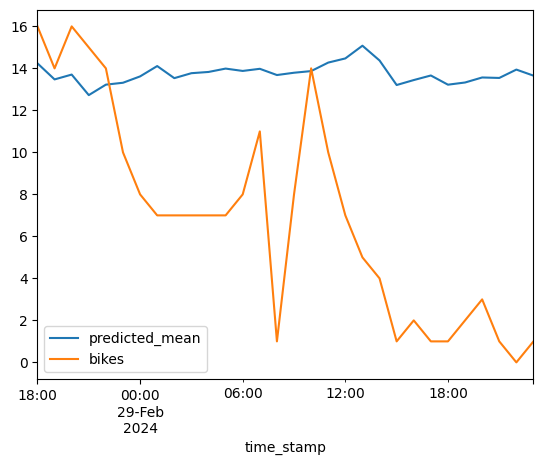

In [23]:
pred.plot(legend=True)
test['bikes'].plot(legend=True)

#

In [24]:
def model_performance_trees(regrssor, output, algorithm):
    regrssor.fit(X_train, y_train[output])
    y_pred = regrssor.predict(X_test)
    print(algorithm, "\t", output)
    mae = mean_absolute_error(y_test[output], y_pred)
    print("MAE : ", mae)
    mse = mean_squared_error(y_test[output], y_pred)
    print("MSE : ", mse)
    r2 = r2_score(y_test[output], y_pred)
    print("R-squared : ", r2)

    plt.scatter(y_test[output], y_pred, marker='.', color='blue' ,edgecolors='red', s=70)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Validation Set Predictions vs. Actual Values')
    plt.show()

In [25]:
def BayesSearch(model, param_space, output):
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_space,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1
    )
    bayes_search.fit(X_train, y_train[output])
    best_params = bayes_search.best_params_
    print("Best parameters found:", best_params)

### XGBoost

In [26]:
from xgboost import XGBRegressor

In [27]:
param_space = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'max_depth': (3, 10),
    'n_estimators': (100, 500),
    'min_child_weight': (1, 10),
    'gamma': (0.0, 1.0, 'uniform'),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform')
}

# regressor_xgb = XGBRegressor()
# BayesSearch(regressor_xgb, param_space, 'bikes')

Best parameters found: OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.15964894124790666, 'learning_rate': 0.09587460498414789, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 500, 'subsample': 0.8997253368774076})

XGBoost 	 bikes
MAE :  4.667837239486409
MSE :  35.684930281500364
R-squared :  0.6308689594834257


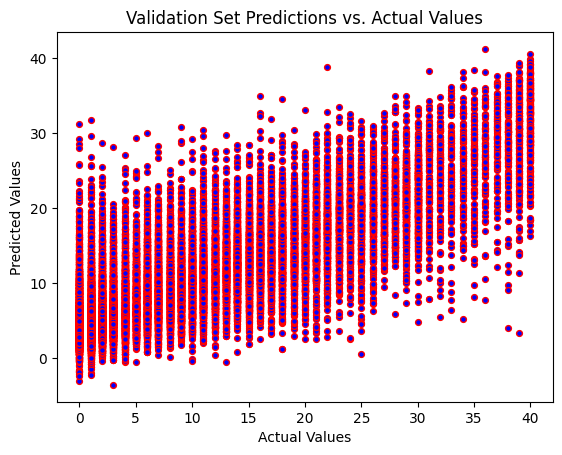

In [28]:
model_xgb = XGBRegressor(colsample_bytree=1.0, 
                        gamma=0.15964894124790666, 
                        learning_rate=0.09587460498414789, 
                        max_depth=6, 
                        min_child_weight=10, 
                        n_estimators=500, 
                        subsample=0.8997253368774076)

model_performance_trees(model_xgb, 'bikes', 'XGBoost')

XGBoost 	 bike_stands
MAE :  4.736931453018254
MSE :  36.91272303513431
R-squared :  0.7056689958477976


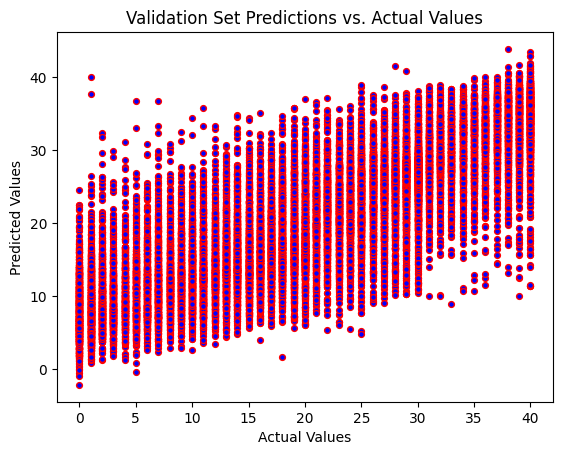

In [29]:
model_xgb2 = XGBRegressor(colsample_bytree=1.0, 
                        gamma=0.15964894124790666, 
                        learning_rate=0.09587460498414789, 
                        max_depth=6, 
                        min_child_weight=10, 
                        n_estimators=500, 
                        subsample=0.8997253368774076)

model_performance_trees(model_xgb2, 'bike_stands', 'XGBoost')

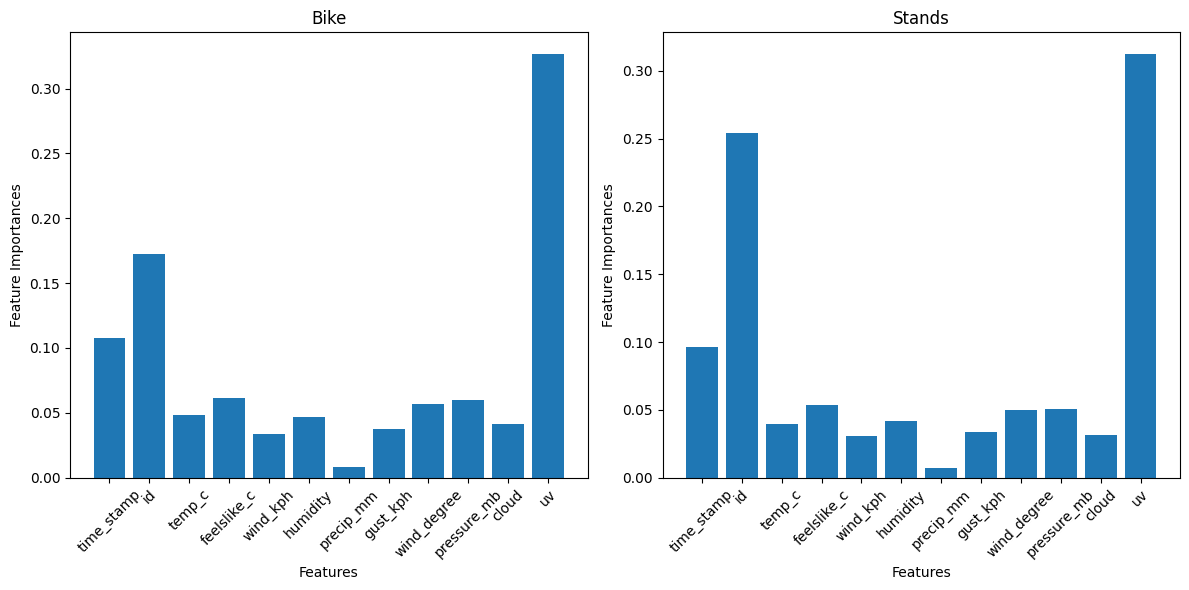

In [30]:
feature_importances_rf2 = model_xgb2.feature_importances_
feature_importances_rf1 = model_xgb.feature_importances_
features = X_train.columns

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(features, feature_importances_rf1)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Bike')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(features, feature_importances_rf2)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Stands')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [31]:
bikes = np.vectorize(round_nearest)(model_xgb.predict(X_test))
stands = np.vectorize(round_nearest)(model_xgb2.predict(X_test))
for i in range(10):
    print(f'Predicted: Bikes={bikes[i]}, Bike Stands={stands[i]} | Actual: Bikes={y_test['bikes'].values[i]}, Bike Stands={y_test['bike_stands'].values[i]}')

Predicted: Bikes=12, Bike Stands=18 | Actual: Bikes=4, Bike Stands=27
Predicted: Bikes=15, Bike Stands=24 | Actual: Bikes=28, Bike Stands=12
Predicted: Bikes=10, Bike Stands=31 | Actual: Bikes=13, Bike Stands=27
Predicted: Bikes=8, Bike Stands=32 | Actual: Bikes=1, Bike Stands=40
Predicted: Bikes=14, Bike Stands=6 | Actual: Bikes=19, Bike Stands=2
Predicted: Bikes=11, Bike Stands=18 | Actual: Bikes=14, Bike Stands=16
Predicted: Bikes=3, Bike Stands=30 | Actual: Bikes=7, Bike Stands=26
Predicted: Bikes=6, Bike Stands=14 | Actual: Bikes=12, Bike Stands=9
Predicted: Bikes=20, Bike Stands=18 | Actual: Bikes=13, Bike Stands=28
Predicted: Bikes=14, Bike Stands=17 | Actual: Bikes=14, Bike Stands=17


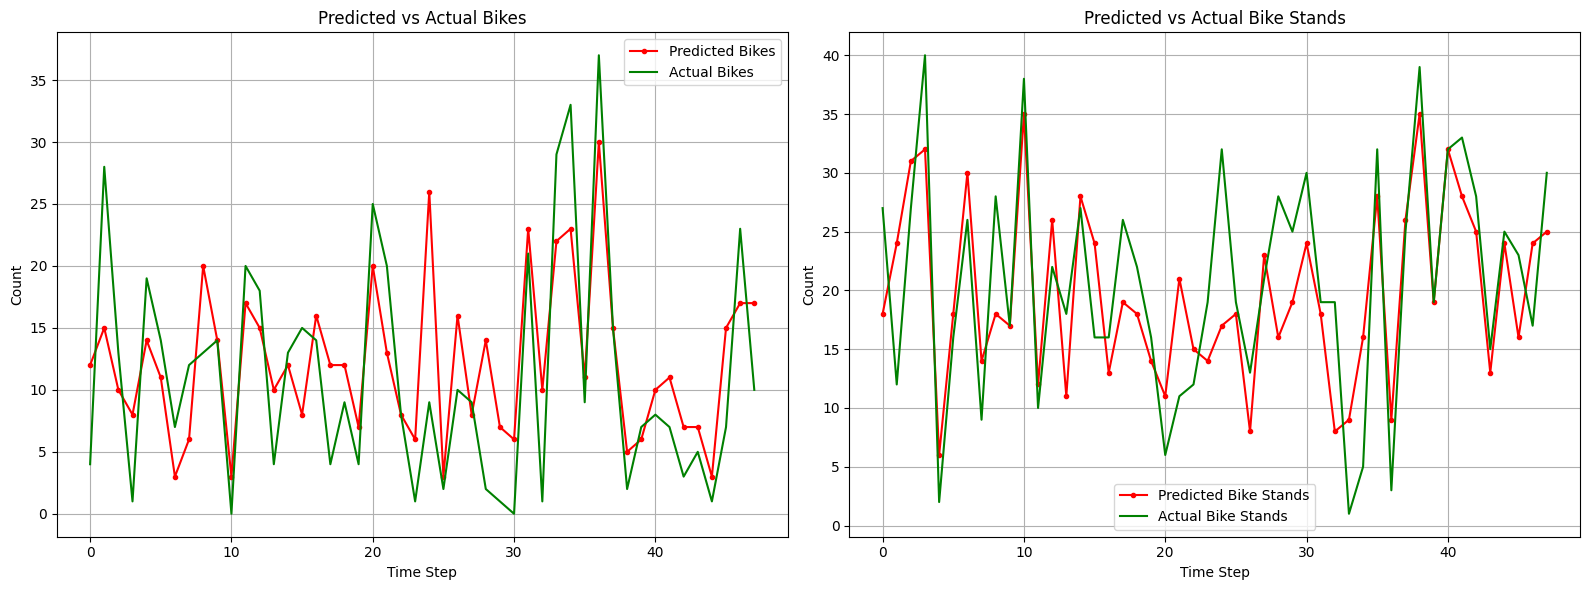

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(np.round(bikes)[:48], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(np.round(y_test['bikes'].values)[:48], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.round(stands)[:48], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(np.round(y_test['bike_stands'].values)[:48], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

#

In [33]:
def model_performance_non_bikes(regrssor, output, algorithm, X_train_processed, y_train_processed, preprocessor, scalar):
    regrssor.fit(X_train_processed, y_train_processed)
    y_pred = regrssor.predict(preprocessor.transform(X_test))
    
    print(algorithm, "\t", output)
    mae = mean_absolute_error(y_test[output], scalar.inverse_transform(y_pred.reshape(-1, 1)))
    print("MAE : ", mae)
    mse = mean_squared_error(y_test[output], scalar.inverse_transform(y_pred.reshape(-1, 1)))
    print("MSE : ", mse)
    r2 = r2_score(y_test[output], scalar.inverse_transform(y_pred.reshape(-1, 1)))
    print("R-squared : ", r2)

    plt.scatter(y_test[output], scalar.inverse_transform(y_pred.reshape(-1, 1)), marker='.', color='blue' ,edgecolors='red', s=70)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Validation Set Predictions vs. Actual Values')
    plt.show()

In [34]:
def BayesSearch_non_tree(model, param_space, y_train_processed, X_train_processed):
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_space,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1
    )
    bayes_search.fit(X_train_processed, y_train_processed)
    best_params = bayes_search.best_params_
    print("Best parameters found:", best_params)

### KNN

In [35]:
from sklearn.neighbors import KNeighborsRegressor

In [85]:
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['time_stamp', 'temp_c', 'feelslike_c', 'wind_kph', 'humidity', 'precip_mm', 'gust_kph', 'wind_degree', 'pressure_mb', 'cloud']),
        ('cat', OneHotEncoder(), ['uv', 'id'])
    ])
X_train_processed = preprocessor_knn.fit_transform(X_train)

In [88]:
scalar1 = StandardScaler()
y_train_processed1 = scalar1.fit_transform(y_train['bikes'].values.reshape(-1, 1))
scalar2 = StandardScaler()
y_train_processed2 = scalar2.fit_transform(y_train['bike_stands'].values.reshape(-1, 1))

In [38]:
param_space = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'p': [1, 2] 
}

# regressor_knn = KNeighborsRegressor()
# BayesSearch_non_tree(regressor_knn, param_space, y_train_processed1, X_train_processed)

Best parameters found: OrderedDict({'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'})

KNN 	 bikes
MAE :  4.300824528968282
MSE :  44.01173878595169
R-squared :  0.5447350238645624


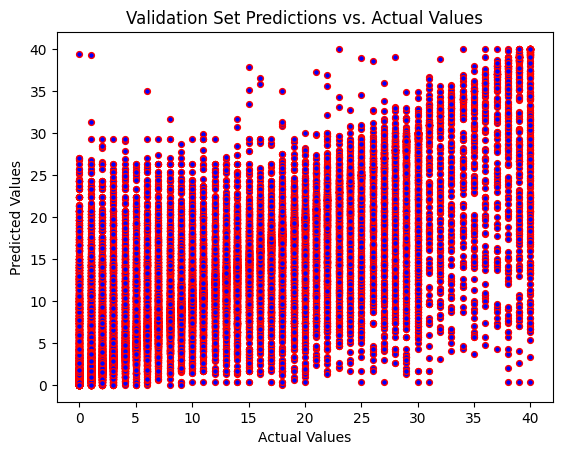

In [89]:
model_knn = KNeighborsRegressor(algorithm='auto', n_neighbors=3, p=1, weights='distance')
model_performance_non_bikes(model_knn, 'bikes', 'KNN', X_train_processed, y_train_processed1, preprocessor_knn, scalar1)

KNN 	 bike_stands
MAE :  4.764278848563956
MSE :  53.89329612001694
R-squared :  0.5702709889763933


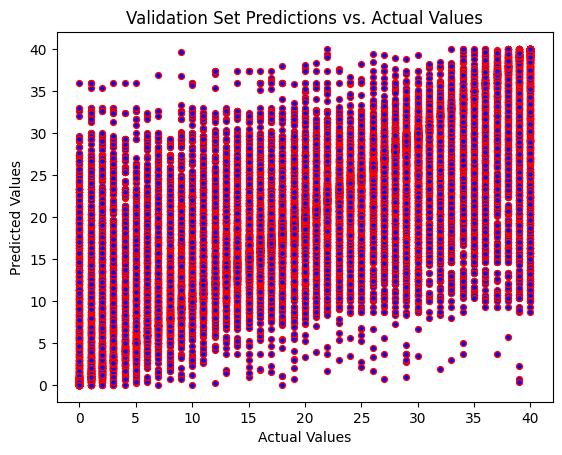

In [90]:
model_knn2 = KNeighborsRegressor(algorithm='auto', n_neighbors=3, p=1, weights='distance')
model_performance_non_bikes(model_knn2, 'bike_stands', 'KNN', X_train_processed, y_train_processed2, preprocessor_knn, scalar2)

In [41]:
bikes = np.vectorize(round_nearest)(scalar1.inverse_transform(model_knn.predict(preprocessor_knn.transform(X_test))))
stands = np.vectorize(round_nearest)(scalar2.inverse_transform(model_knn2.predict(preprocessor_knn.transform(X_test))))
for i in range(10):
    print(f'Predicted: Bikes={np.round(bikes)[i]}, Bike Stands={np.round(stands)[i]} | Actual: Bikes={np.round(y_test['bikes'].values)[i]}, Bike Stands={np.round(y_test['bike_stands'].values)[i]}')

Predicted: Bikes=[8], Bike Stands=[23] | Actual: Bikes=4, Bike Stands=27
Predicted: Bikes=[20], Bike Stands=[21] | Actual: Bikes=28, Bike Stands=12
Predicted: Bikes=[13], Bike Stands=[28] | Actual: Bikes=13, Bike Stands=27
Predicted: Bikes=[11], Bike Stands=[23] | Actual: Bikes=1, Bike Stands=40
Predicted: Bikes=[14], Bike Stands=[16] | Actual: Bikes=19, Bike Stands=2
Predicted: Bikes=[11], Bike Stands=[15] | Actual: Bikes=14, Bike Stands=16
Predicted: Bikes=[8], Bike Stands=[32] | Actual: Bikes=7, Bike Stands=26
Predicted: Bikes=[13], Bike Stands=[8] | Actual: Bikes=12, Bike Stands=9
Predicted: Bikes=[6], Bike Stands=[26] | Actual: Bikes=13, Bike Stands=28
Predicted: Bikes=[16], Bike Stands=[12] | Actual: Bikes=14, Bike Stands=17


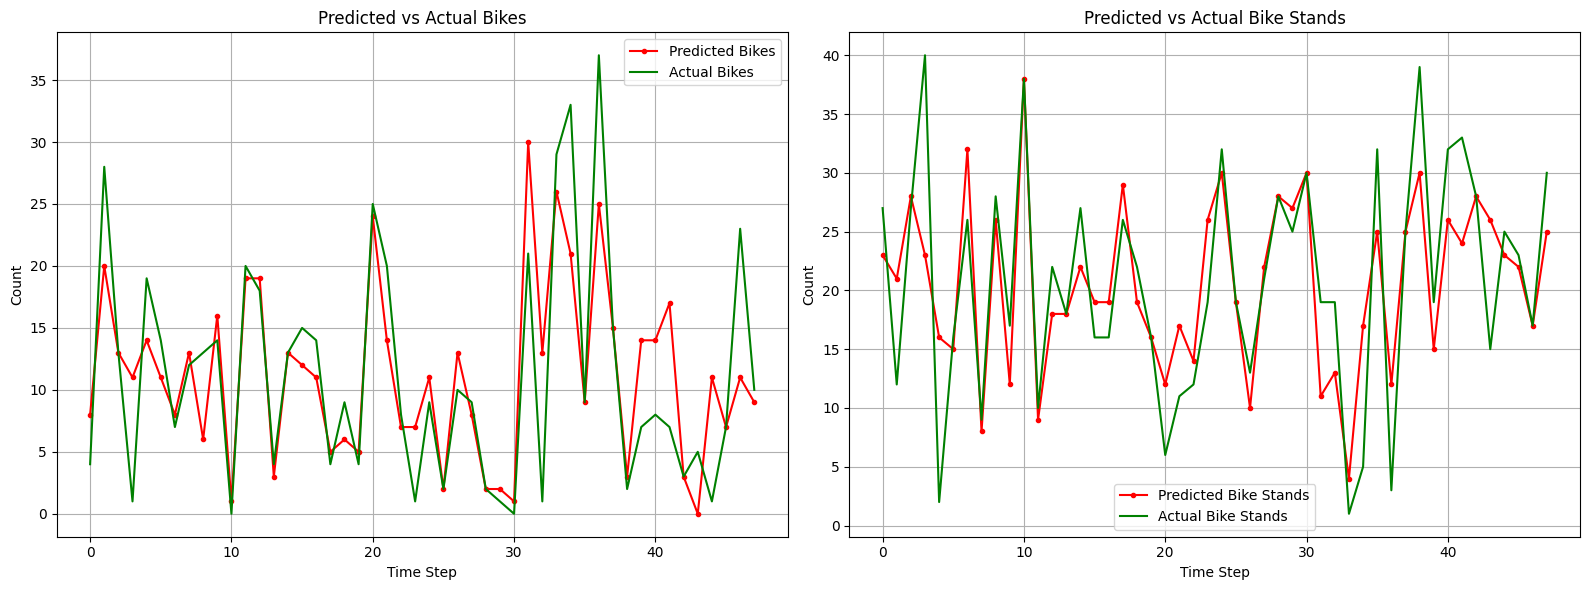

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(np.round(bikes)[:48], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(np.round(y_test['bikes'].values)[:48], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.round(stands)[:48], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(np.round(y_test['bike_stands'].values)[:48], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()

### ANN

In [43]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [91]:
preprocessor_ann = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['time_stamp', 'temp_c', 'feelslike_c', 'wind_kph', 'humidity', 'precip_mm', 'gust_kph', 'wind_degree', 'pressure_mb', 'cloud']),
        ('cat', OneHotEncoder(), ['uv', 'id'])
    ])
X_train_processed = preprocessor_ann.fit_transform(X_train)
scalar = MinMaxScaler()
y_train_processed = scalar.fit_transform(y_train.values)

In [92]:
input_shape = X_train_processed.shape[1:]

In [106]:
ann_model = Sequential([
    Dense(256, activation='relu', input_shape=input_shape),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(2)
])
ann_model.compile(optimizer='adam', loss='mse')

In [107]:
ann_model.fit(X_train_processed.toarray(), y_train_processed, epochs=10, batch_size=8, validation_data=(preprocessor_ann.transform(X_test).toarray(), scalar.transform(y_test.values)))

Epoch 1/10


16405/16405 ━━━━━━━━━━━━━━━━━━━━ 11s 637us/step - loss: 0.0410 - val_loss: 0.0292
Epoch 2/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 10s 639us/step - loss: 0.0270 - val_loss: 0.0245
Epoch 3/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 11s 654us/step - loss: 0.0221 - val_loss: 0.0221
Epoch 4/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 10s 638us/step - loss: 0.0193 - val_loss: 0.0192
Epoch 5/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 11s 647us/step - loss: 0.0171 - val_loss: 0.0185
Epoch 6/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 10s 639us/step - loss: 0.0156 - val_loss: 0.0175
Epoch 7/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 11s 660us/step - loss: 0.0144 - val_loss: 0.0167
Epoch 8/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 11s 664us/step - loss: 0.0136 - val_loss: 0.0164
Epoch 9/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 11s 653us/step - loss: 0.0127 - val_loss: 0.0154
Epoch 10/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 11s 652us/step - loss: 0.0122 - val_loss: 0.0144


In [108]:
X_test_processed = preprocessor_ann.transform(X_test)
y_pred = ann_model.predict(X_test_processed.toarray())

1026/1026 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


In [109]:
predictions_inv = scalar.inverse_transform(y_pred)
y_test_inv = y_test.values

predictions_inv= np.vectorize(round_nearest)(predictions_inv)
y_test_inv = np.vectorize(round_nearest)(y_test_inv)

for i in range(10):
    print(f'Predicted: Bikes={predictions_inv[i][0]}, Bike Stands={predictions_inv[i][1]} | Actual: Bikes={y_test_inv[i][0]}, Bike Stands={y_test_inv[i][1]}')

Predicted: Bikes=11, Bike Stands=20 | Actual: Bikes=4, Bike Stands=27
Predicted: Bikes=26, Bike Stands=13 | Actual: Bikes=28, Bike Stands=12
Predicted: Bikes=14, Bike Stands=26 | Actual: Bikes=13, Bike Stands=27
Predicted: Bikes=4, Bike Stands=37 | Actual: Bikes=1, Bike Stands=40
Predicted: Bikes=18, Bike Stands=3 | Actual: Bikes=19, Bike Stands=2
Predicted: Bikes=11, Bike Stands=20 | Actual: Bikes=14, Bike Stands=16
Predicted: Bikes=3, Bike Stands=30 | Actual: Bikes=7, Bike Stands=26
Predicted: Bikes=16, Bike Stands=4 | Actual: Bikes=12, Bike Stands=9
Predicted: Bikes=13, Bike Stands=27 | Actual: Bikes=13, Bike Stands=28
Predicted: Bikes=16, Bike Stands=15 | Actual: Bikes=14, Bike Stands=17


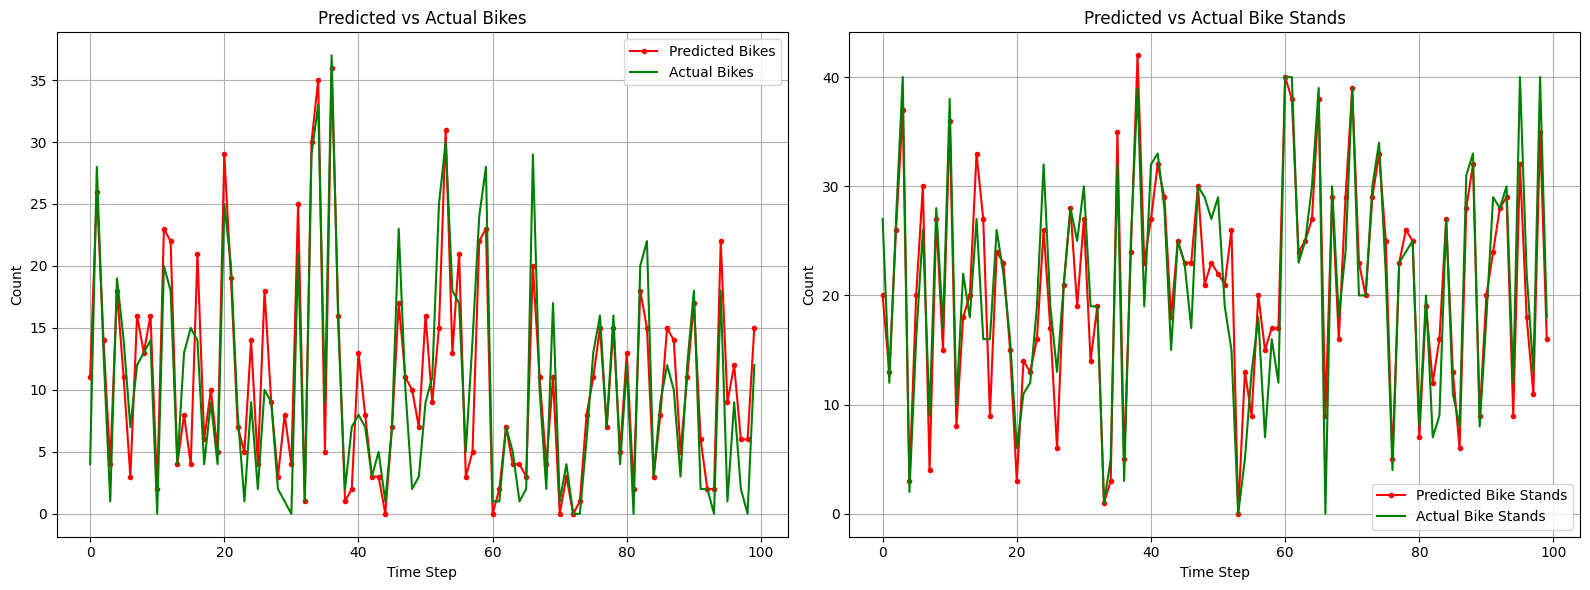

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(predictions_inv[:100, 0], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(y_test_inv[:100, 0], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(predictions_inv[:100, 1], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(y_test_inv[:100, 1], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [111]:
predict_test = scalar.inverse_transform(y_pred)

mae = mean_absolute_error(y_test, predict_test)
print("MAE : ", mae)
mse = mean_squared_error(y_test, predict_test)
print("MSE : ", mse)
r2 = r2_score(y_test, predict_test)
print("R-squared : ", r2)

MAE :  3.4840346816072225
MSE :  23.101940004654722
R-squared :  0.7885118001344578


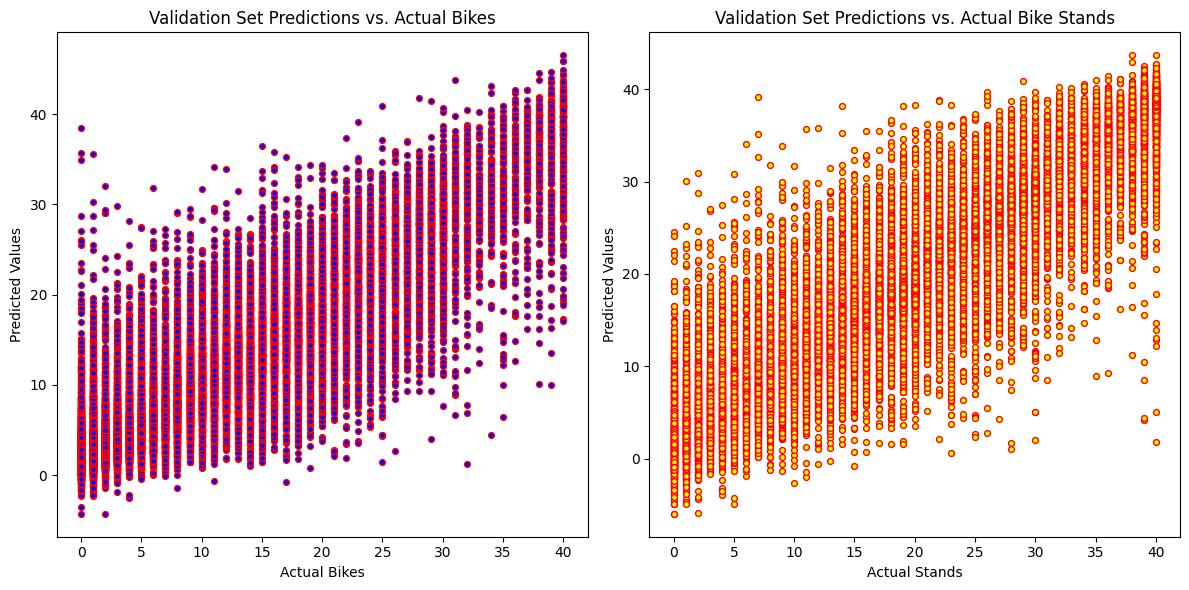

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(y_test['bikes'], predict_test[:, 0], marker='.', color='blue' ,edgecolors='red', s=70)
axs[0].set_xlabel('Actual Bikes')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Validation Set Predictions vs. Actual Bikes')

axs[1].scatter(y_test['bike_stands'], predict_test[:, 1], marker='.', color='yellow' ,edgecolors='red', s=70)
axs[1].set_xlabel('Actual Stands')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Validation Set Predictions vs. Actual Bike Stands')

plt.tight_layout()
plt.show()

### RNN

In [116]:
from keras.layers import LSTM, Dropout

In [117]:
df_rnn = df[df['id'] == 42]
# df_rnn = df.copy()
df_rnn['time_stamp'] = pd.to_datetime(df_rnn['time_stamp'])
df_rnn.set_index('time_stamp', inplace=True)
df_rnn = df_rnn.drop('id', axis=1)
X = df_rnn.drop(columns=['bikes', 'bike_stands'])
y = df_rnn[['bikes', 'bike_stands']]

In [118]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [119]:
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(data.shape[0] - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

In [120]:
sequence_length = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

In [121]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [122]:
X_train_rnn.shape

(1132, 24, 10)

In [123]:
model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.1),
    LSTM(units=128, return_sequences=False),
    Dense(units=2)
])

model.compile(optimizer='adam', loss='mse')

In [124]:
model.fit(X_train_rnn, y_train_rnn, epochs=10, batch_size=16)

Epoch 1/10


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.8730
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4990
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3325
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2421
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2239
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1703
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1427
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1366
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1094
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0956


In [125]:
loss = model.evaluate(X_test_rnn, y_test_rnn)
print(f'Test Loss: {loss}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1626 
Test Loss: 0.15180176496505737


In [126]:
predictions = model.predict(X_test_rnn)

predictions_inv = scaler_y.inverse_transform(predictions)
y_test_inv = scaler_y.inverse_transform(y_test_rnn)

predictions_inv = np.vectorize(round_nearest)(predictions_inv)
y_test_inv = np.vectorize(round_nearest)(y_test_inv)

for i in range(10):
    print(f'Predicted: Bikes={predictions_inv[i][0]}, Bike Stands={predictions_inv[i][1]} | Actual: Bikes={y_test_inv[i][0]}, Bike Stands={y_test_inv[i][1]}')

1/9 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted: Bikes=23, Bike Stands=7 | Actual: Bikes=28, Bike Stands=3
Predicted: Bikes=27, Bike Stands=4 | Actual: Bikes=30, Bike Stands=0
Predicted: Bikes=23, Bike Stands=9 | Actual: Bikes=24, Bike Stands=6
Predicted: Bikes=27, Bike Stands=3 | Actual: Bikes=23, Bike Stands=7
Predicted: Bikes=8, Bike Stands=22 | Actual: Bikes=2, Bike Stands=28
Predicted: Bikes=20, Bike Stands=11 | Actual: Bikes=21, Bike Stands=10
Predicted: Bikes=29, Bike Stands=1 | Actual: Bikes=30, Bike Stands=0
Predicted: Bikes=19, Bike Stands=12 | Actual: Bikes=20, Bike Stands=10
Predicted: Bikes=25, Bike Stands=5 | Actual: Bikes=23, Bike Stands=7
Predicted: Bikes=16, Bike Stands=14 | Actual: Bikes=16, Bike Stands=14


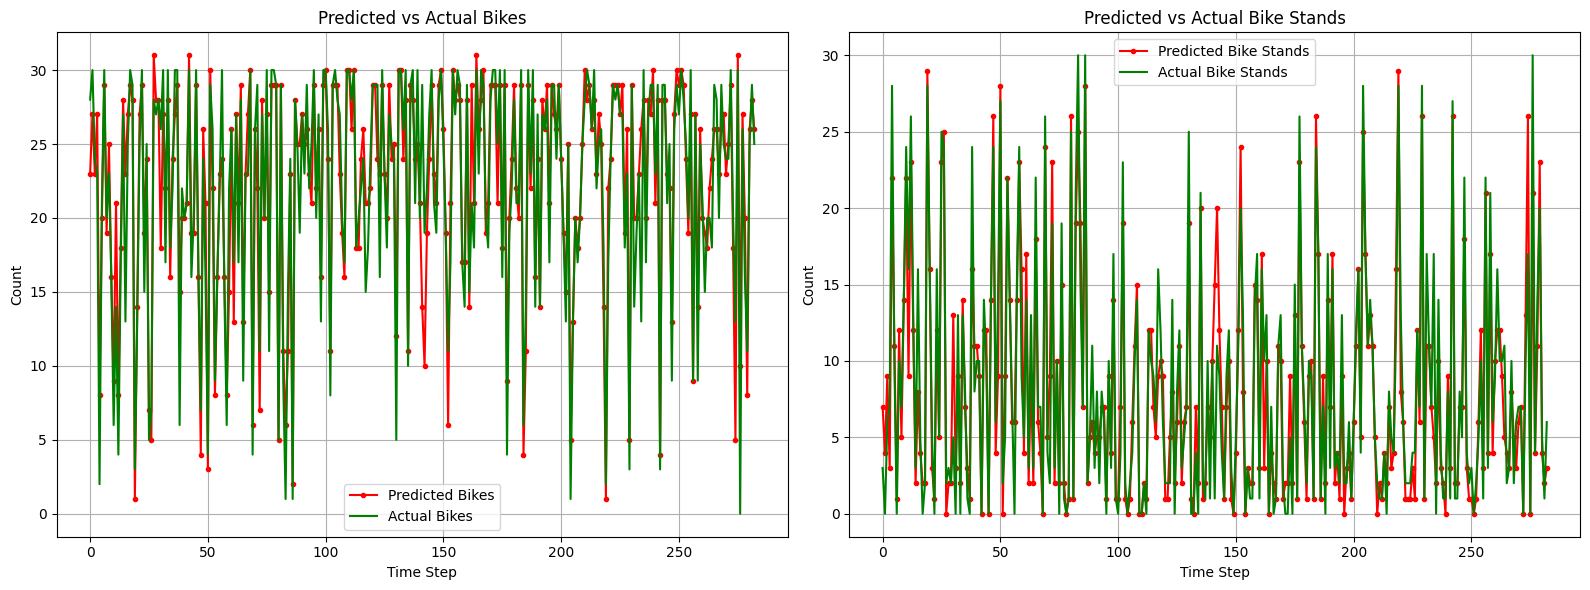

In [130]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(predictions_inv[:100, 0], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(y_test_inv[:100, 0], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(predictions_inv[:100, 1], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(y_test_inv[:100, 1], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [128]:
mae = mean_absolute_error(predictions_inv[:,0], y_test_inv[:,0])
print("MAE : ", mae)
mse = mean_squared_error(predictions_inv[:,0], y_test_inv[:,0])
print("MSE : ", mse)
r2 = r2_score(predictions_inv[:,0], y_test_inv[:,0])
print("R-squared : ", r2)

MAE :  2.060070671378092
MSE :  9.063604240282686
R-squared :  0.8233288777862584


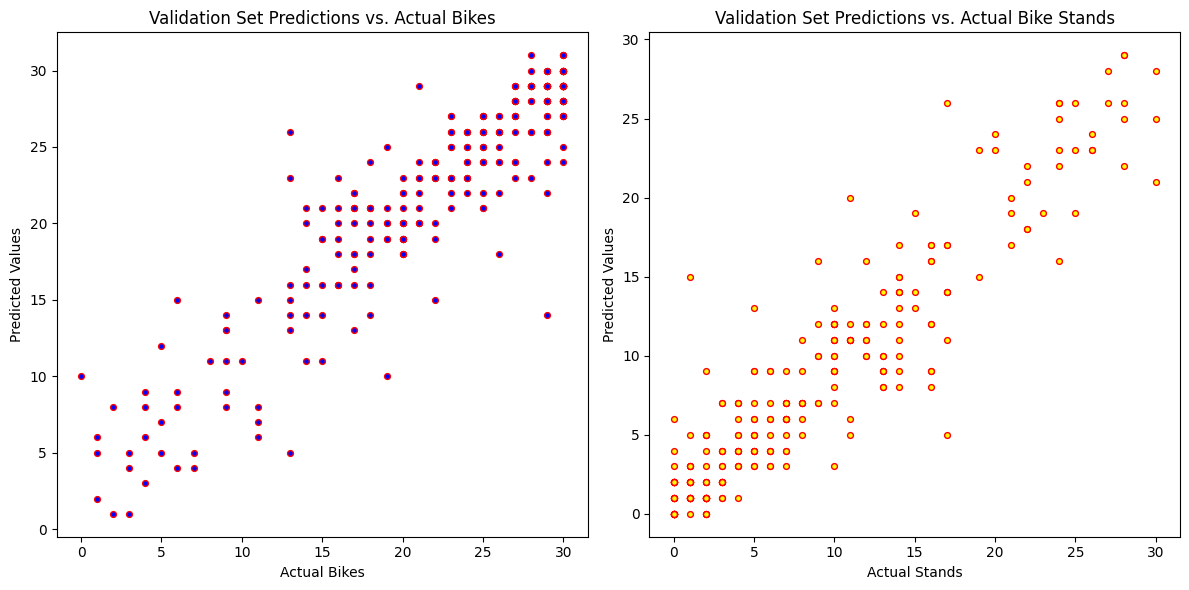

In [129]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(y_test_inv[:,0], predictions_inv[:,0], marker='.', color='blue' ,edgecolors='red', s=70)
axs[0].set_xlabel('Actual Bikes')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Validation Set Predictions vs. Actual Bikes')

axs[1].scatter(y_test_inv[:,1], predictions_inv[:,1], marker='.', color='yellow' ,edgecolors='red', s=70)
axs[1].set_xlabel('Actual Stands')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Validation Set Predictions vs. Actual Bike Stands')

plt.tight_layout()
plt.show()

#

#

In [67]:
from datetime import datetime
import requests
import json
import pandas as pd

link = ' http://api.weatherapi.com/v1/current.json'
api = '1afd61b9571f4d8a8f7133239242702'
contract = 'Dublin'

response = requests.get(link, 
                        params={"key": api, 
                                "q": contract})
response.raise_for_status()
now = datetime.now()
data = response.text
data = json.loads(data)
data = pd.json_normalize(data)
data.columns

Index(['location.name', 'location.region', 'location.country', 'location.lat',
       'location.lon', 'location.tz_id', 'location.localtime_epoch',
       'location.localtime', 'current.last_updated_epoch',
       'current.last_updated', 'current.temp_c', 'current.temp_f',
       'current.is_day', 'current.condition.text', 'current.condition.icon',
       'current.condition.code', 'current.wind_mph', 'current.wind_kph',
       'current.wind_degree', 'current.wind_dir', 'current.pressure_mb',
       'current.pressure_in', 'current.precip_mm', 'current.precip_in',
       'current.humidity', 'current.cloud', 'current.feelslike_c',
       'current.feelslike_f', 'current.vis_km', 'current.vis_miles',
       'current.uv', 'current.gust_mph', 'current.gust_kph'],
      dtype='object')

In [68]:
sample = pd.DataFrame()
sample['time_stamp'] = pd.to_datetime(data['location.localtime']).dt.round('H')
sample['temp_c'] = data['current.temp_c']
sample['feelslike_c'] = data['current.feelslike_c']
sample['wind_kph'] = data['current.wind_kph']
sample['humidity'] = data['current.humidity']
sample['precip_mm'] = data['current.precip_mm']
sample['gust_kph'] = data['current.gust_kph']
sample['wind_degree'] = data['current.wind_degree']
sample['pressure_mb'] = data['current.pressure_mb']
sample['cloud'] = data['current.cloud']
sample['uv'] = data['current.uv']

In [69]:
from datetime import datetime
import requests
import json

link = 'https://api.jcdecaux.com/vls/v1/stations'
api = '681b757e032447abea03a11443b614d0ba3cf5ef'
contract = 'Dublin'

response = requests.get(link, 
                        params={"apiKey": api, 
                                "contract": contract})
response.raise_for_status()
now = datetime.now()
data = response.text
data = json.loads(data)
data = pd.json_normalize(data)

In [70]:
data.columns

Index(['number', 'contract_name', 'name', 'address', 'banking', 'bonus',
       'bike_stands', 'available_bike_stands', 'available_bikes', 'status',
       'last_update', 'position.lat', 'position.lng'],
      dtype='object')

In [71]:
sample2 = pd.DataFrame()
sample2['id'] = data['number']
sample2['time_stamp'] = pd.to_datetime(data['last_update'], unit='ms').dt.round('H')

In [72]:
result = pd.merge(sample, sample2, on='time_stamp', how='inner')
result['time_stamp'] = (result['time_stamp'].astype(int) / 10**9).astype(int)

In [73]:
X_sample = preprocessor_ann.transform(result)

In [100]:
pred = ann_model.predict(X_sample.toarray())


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step


In [101]:
pred_inv = scalar.inverse_transform(pred)
pred_inv = np.vectorize(round_nearest)(pred_inv)
y_true = data[['available_bike_stands', 'available_bikes']]
for i in range(10):
    print(f'Predicted: Bikes={pred_inv[i][0]}, Bike Stands={pred_inv[i][1]} | Actual: Bikes={y_true['available_bikes'].values[i]}, Bike Stands={y_true['available_bike_stands'].values[i]}')

Predicted: Bikes=11, Bike Stands=25 | Actual: Bikes=28, Bike Stands=2
Predicted: Bikes=9, Bike Stands=21 | Actual: Bikes=0, Bike Stands=20
Predicted: Bikes=15, Bike Stands=25 | Actual: Bikes=27, Bike Stands=6
Predicted: Bikes=11, Bike Stands=29 | Actual: Bikes=1, Bike Stands=34
Predicted: Bikes=27, Bike Stands=13 | Actual: Bikes=3, Bike Stands=27
Predicted: Bikes=24, Bike Stands=18 | Actual: Bikes=6, Bike Stands=34
Predicted: Bikes=9, Bike Stands=23 | Actual: Bikes=0, Bike Stands=20
Predicted: Bikes=9, Bike Stands=29 | Actual: Bikes=7, Bike Stands=23
Predicted: Bikes=22, Bike Stands=16 | Actual: Bikes=24, Bike Stands=6
Predicted: Bikes=12, Bike Stands=27 | Actual: Bikes=26, Bike Stands=6


In [102]:
pred_inv.shape

(114, 2)

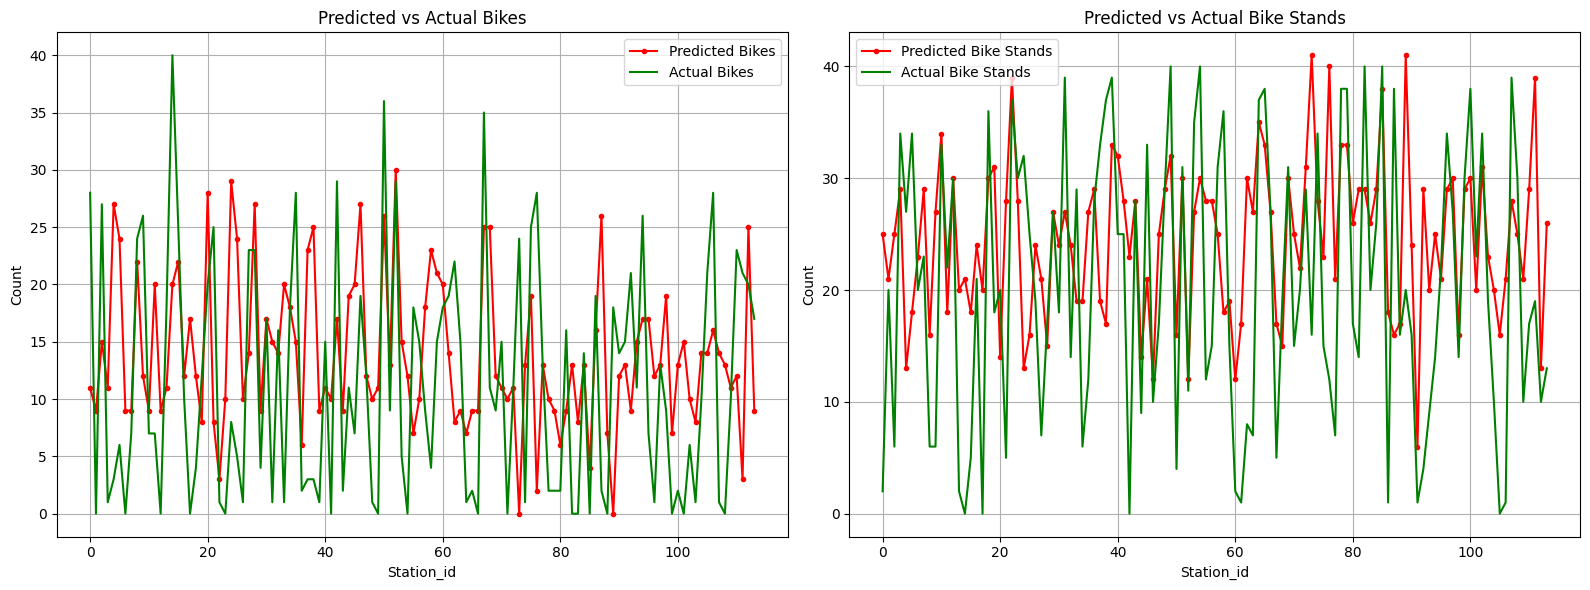

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(pred_inv[:, 0], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(y_true['available_bikes'].values, label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Station_id')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(pred_inv[:, 1], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(y_true['available_bike_stands'].values, label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Station_id')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

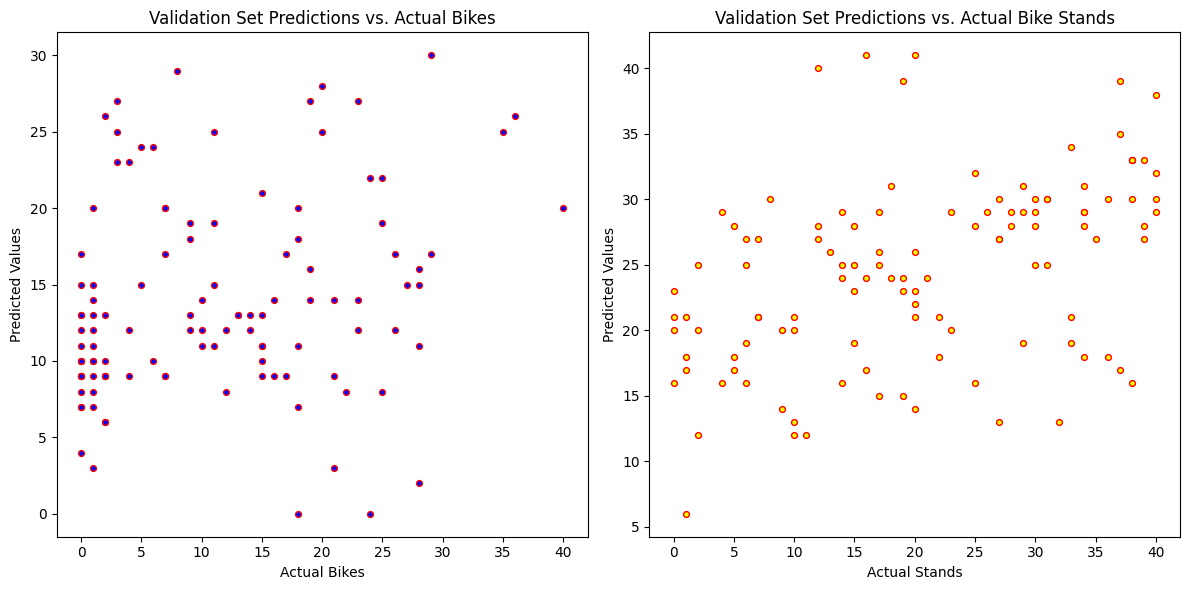

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(y_true['available_bikes'].values, pred_inv[:, 0], marker='.', color='blue' ,edgecolors='red', s=70)
axs[0].set_xlabel('Actual Bikes')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Validation Set Predictions vs. Actual Bikes')

axs[1].scatter(y_true['available_bike_stands'].values, pred_inv[:, 1], marker='.', color='yellow' ,edgecolors='red', s=70)
axs[1].set_xlabel('Actual Stands')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Validation Set Predictions vs. Actual Bike Stands')

plt.tight_layout()
plt.show()

In [105]:
mae = mean_absolute_error(y_true.values, pred_inv)
print("MAE : ", mae)
mse = mean_squared_error(y_true.values, pred_inv)
print("MSE : ", mse)
r2 = r2_score(y_true.values, pred_inv)
print("R-squared : ", r2)

MAE :  14.855263157894736
MSE :  304.1359649122807
R-squared :  -1.589430075847089


In [80]:
import numpy as np
from keras.models import load_model
import pickle

bikes = []
stands = []
for i in data['number'].unique():

    model_path = f"../models/ava_weather/RNN/rnn_{i}.keras"
    scaler_path = f"../models/ava_weather/RNN/model_data/scaler_{i}.pkl"

    with open(scaler_path, 'rb') as model_file:
        model_data = pickle.load(model_file)
    
    scaler_X = model_data['scaler_X']
    scaler_y = model_data['scaler_y']

    model = load_model(model_path)
    
    new_df = sample.copy()
    new_df['time_stamp'] = pd.to_datetime(new_df['time_stamp'])
    new_df.set_index('time_stamp', inplace=True)
    new_df_scaled = scaler_X.transform(new_df)

    print("Shape of scaled new data:", new_df_scaled.shape)
    new_data_reshaped = np.reshape(new_df_scaled, (1, new_df_scaled.shape[0], new_df_scaled.shape[1]))
    predicted_scaled = model.predict(new_data_reshaped)

    predicted = scaler_y.inverse_transform(predicted_scaled)
    bikes.append(predicted[0][0])
    stands.append(predicted[0][1])

Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━

In [81]:
bikes = [round_nearest(i) for i in bikes]
stands = [round_nearest(i) for i in stands]

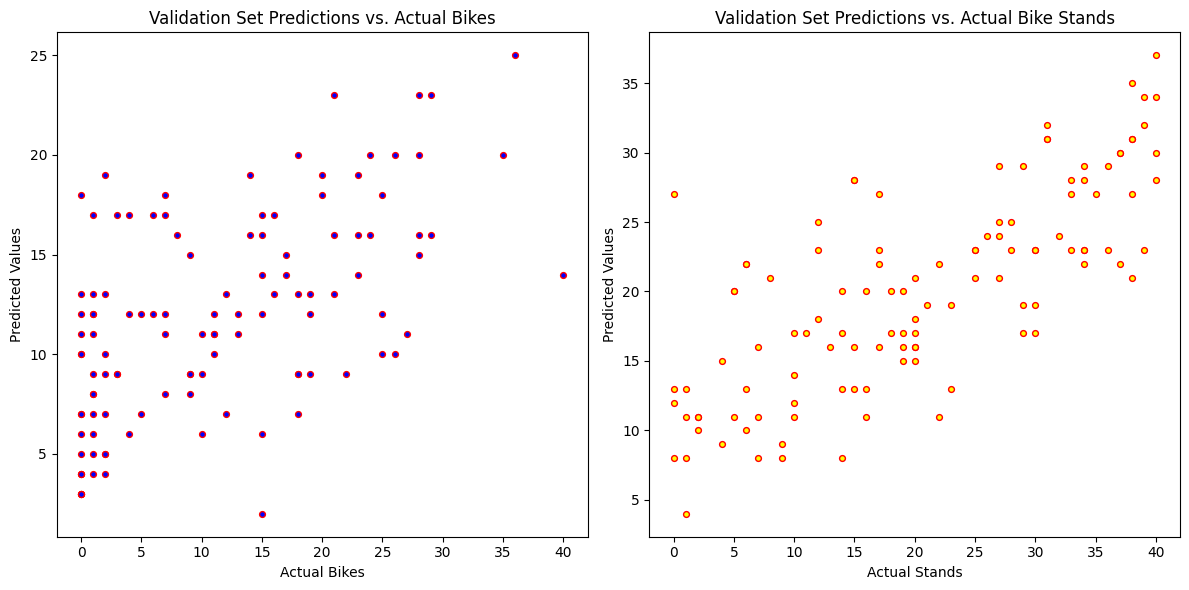

In [82]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(data['available_bikes'].values, bikes, marker='.', color='blue' ,edgecolors='red', s=70)
axs[0].set_xlabel('Actual Bikes')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Validation Set Predictions vs. Actual Bikes')

axs[1].scatter(data['available_bike_stands'].values, stands, marker='.', color='yellow' ,edgecolors='red', s=70)
axs[1].set_xlabel('Actual Stands')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Validation Set Predictions vs. Actual Bike Stands')

plt.tight_layout()
plt.show()

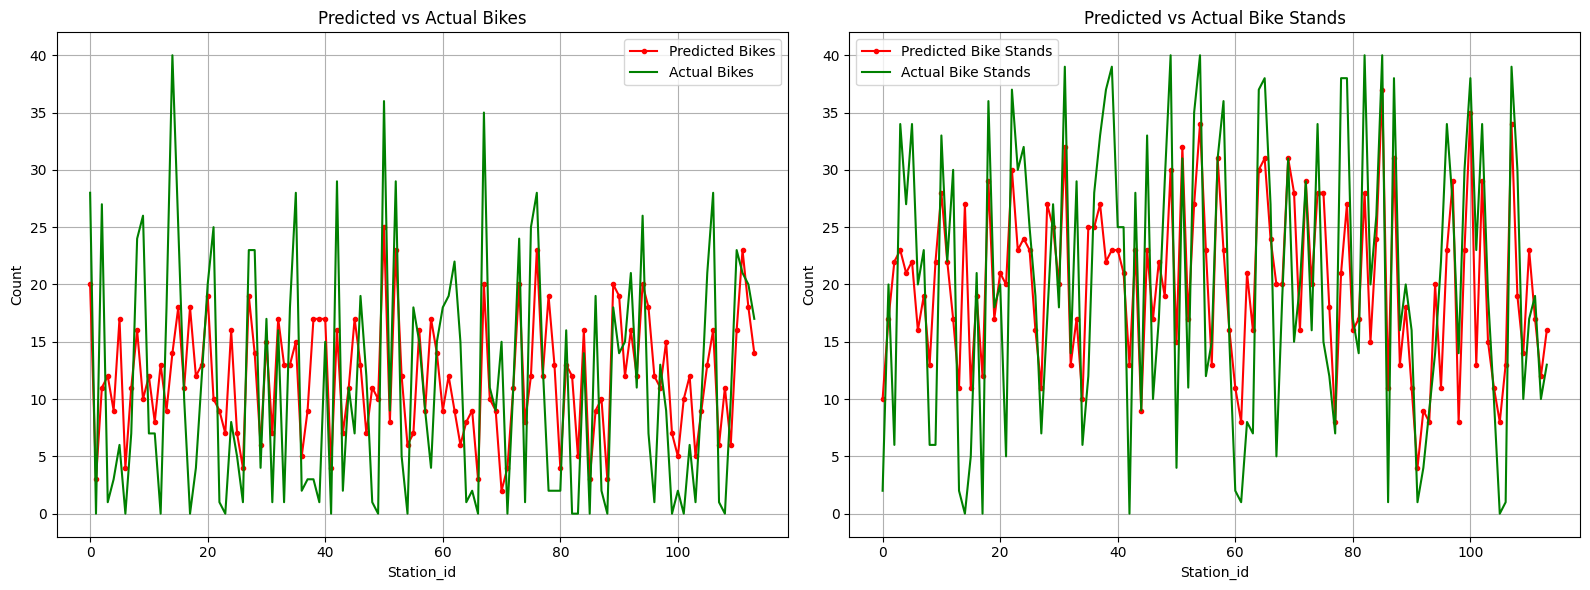

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(bikes[:], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(data['available_bikes'][:].values, label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Station_id')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(stands[:], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(data['available_bike_stands'].values[:], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Station_id')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [84]:
mae = mean_absolute_error(y_true.values, pred_inv)
print("MAE : ", mae)
mse = mean_squared_error(y_true.values, pred_inv)
print("MSE : ", mse)
r2 = r2_score(y_true.values, pred_inv)
print("R-squared : ", r2)

MAE :  13.666666666666668
MSE :  270.3070175438596
R-squared :  -1.2356328832872763


#